<a href="https://colab.research.google.com/github/dkrieger94/intro/blob/master/private.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numbers
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.special import erf

import matplotlib.pyplot as plt

# Some useful time conversion factors
seconds_per_minute = 60.
minutes_per_hour = 60.
hours_per_day = 24.
days_per_year = 365.2422
seconds_per_hour = minutes_per_hour * seconds_per_minute
minutes_per_day = hours_per_day * minutes_per_hour
seconds_per_day = hours_per_day * seconds_per_hour
seconds_per_year = seconds_per_day * days_per_year

A = 204.  # Budyko Sellers approximation constants (W / m**2)
B = 2.17

a = 5.4  # constant for OLR modification by CO2 (W / m**2)

sigma = 5.6703726226e-08  # Stefan-Boltzmann constant (W / m**2 / K**4)
S0 = 1365.2  # solar constant (W / m**2)
emss = 0.6  # atmosphere emissivity

rho_w = 1028.  # density of water (kg / m**3)
cw = 4200.  # specific heat of liquid water (J / kg / K)

Ts_0 = 286.73  # estimated global mean temperature (1850-1900 avg)

# carbon cycle
k_a = 2.12  # (GtC / ppm) ---> atmosphere

co2 = 280.  # pre-industrial atmospheric CO2 concentration (ppm)
g_e = 0.005 / seconds_per_year  # (GtC / ppm) / s
ge_ka = g_e / k_a  # 1 / s
zeta = 10.5
mu_0 = 5.0 / seconds_per_year  # Ocean carbon transfer rate (m / s)

tau_l = 41. * seconds_per_year  # reference lifetime of land carbon (yr)
q_10 = 1.8  # increase in respiration with a 10K temp. increase
beta_fertil = 0.4  # CO2 fertilization factor
npp_0 = 60. / seconds_per_year  # pre-industrial net primary productivity (GtC / yr)
cl_0 = 2500.  # pre-industrial land carbon storage (GtC)

emss_0 = 36. / seconds_per_year  # (GtC / s)


class ESM:

    def __init__(self,
                 initial_state=None,
                 insolation=0.25 * S0,
                 albedo_atm=0.0,
                 albedo_land=0.29,
                 albedo_icefree=0.2,
                 albedo_ice=0.6,
                 albedo_ref_temperature=273.15,
                 albedo_b=0.05,
                 albedo_carbon_coeff=-0.01,
                 emissivity=emss,
                 emissivity_gradient=0.01,
                 emissivity_t_ref=288.,
                 depth_s=75.0,
                 depth_d=3750.0,
                 emissions_scenario=None,
                 transient_rad_resp=0.0,
                 mixing_scale=3.2,
                 lin_olr=False,
                 use_constant_albedo_land=True,
                 use_constant_albedo_icefree=True,
                 use_constant_emissivity=True,
                 reference_year=1850,
                 active_components=3):

        # albedo parameters
        if initial_state is None:
            initial_state = {'ts': Ts_0, 'td': Ts_0 - 10}
        self.albedo_atm = albedo_atm  # atmospheric albedo
        self.albedo_land = albedo_land
        self.albedo_icefree = albedo_icefree  # land albedo in hothouse climate
        self.albedo_ice = albedo_ice  # land albedo in snowball climate
        self.albedo_ref_temperature = albedo_ref_temperature  # reference temperature for albedo transition zone
        self.albedo_b = albedo_b  # albedo error function tuning parameter
        self.albedo_carbon_coeff = albedo_carbon_coeff  # albedo dependence on carbon
        self.use_constant_albedo_land = use_constant_albedo_land
        self.use_constant_albedo_icefree = use_constant_albedo_icefree

        self.insolation = insolation
        self.lin_olr = lin_olr

        # emissivity
        self.emss = emissivity
        self.emss_gradient = emissivity_gradient  # change in emissivity with temperature (1 / K)
        self.emss_t_ref = emissivity_t_ref  # reference temperature for which emissivity = self.emss
        self.use_constant_emissivity = use_constant_emissivity

        # atmosphere-ocean coupling parameters
        self.eta = mixing_scale
        self.lambda_t = transient_rad_resp

        # pre-industrial ocean carbon storage [ GtC ]

        self.nu_o = 1./6.   # ocean-atmosphere carbon ratio
        self.cl_0 = cl_0
        self.ca_0 = co2 * k_a
        self.co_0 = zeta * self.ca_0 / self.nu_o
        self.cs_0 = self.co_0 * depth_s / (depth_s + depth_d)
        self.cd_0 = self.co_0 - self.cs_0
        self.nu_s = zeta * (self.ca_0 / self.cs_0) # surface-atmosphere carbon ratio

        # Anthropogenic emissions
        self.reference_year = reference_year
        self.Ts_0 = Ts_0  # estimated global mean temperature (1850-1900 avg)

        if emissions_scenario is None:
            emissions_scenario = emss_0

        if isinstance(emissions_scenario, numbers.Number):
            # constant emission scenario                             (GtC / yr)
            self.em = lambda t: emissions_scenario
        elif callable(emissions_scenario):
            # Time dependent function                                (GtC / yr)
            self.em = emissions_scenario
        elif hasattr(emissions_scenario, '__len__'):
            # Time series (filename / array)                         (GtC / yr)

            if isinstance(emissions_scenario, str):
                # Assuming a filename is given as string
                em_data = np.array(pd.read_csv(emissions_scenario, sep=',')).T
            else:
                em_data = np.asanyarray(emissions_scenario)

            em_data[1] /= seconds_per_year  # add unit checking of data in file
            # Create interpolation function from data points
            interp_fun = interp1d(*em_data,
                                  kind='linear', bounds_error=False,
                                  fill_value=(em_data[1, 0], em_data[1, -1]))
            self.em = lambda t: interp_fun(t)

        else:
            raise ValueError(
                "Parameter 'emissions' must be a scalar, a filename (string),"
                " a Nx2 sequence or a callable function")

        # -----------------------------------------------------------------------
        # Model state initialization:
        # -----------------------------------------------------------------------
        self.model_state = {}

        if isinstance(initial_state, dict):
            vnames = initial_state.keys()
            assert 'ts' in vnames, "Model state must contain at least 'ts'"

            self.model_state['ts'] = initial_state['ts']
            if 'td' not in vnames:
                self.model_state['td'] = initial_state['ts'] - 10.0
            else:
                self.model_state['td'] = initial_state['td']

            if 'ca' not in vnames:  # Atmospheric   carbon storage (GtC)
                self.model_state['ca'] = self.ca_0
            else:
                self.model_state['ca'] = initial_state['ca'] * k_a

            if 'cs' not in vnames:  # Surface Ocean carbon storage (GtC)
                self.model_state['cs'] = self.cs_0
            else:
                self.model_state['cs'] = initial_state['cs']

            if 'cd' not in vnames:  # Deep Ocean    carbon storage (GtC)
                self.model_state['cd'] = self.cd_0
            else:
                self.model_state['cd'] = initial_state['cd']

            if 'cl' not in vnames:  # Terrestrial   carbon storage (GtC)
                self.model_state['cl'] = self.cl_0
            else:
                self.model_state['cl'] = initial_state['cl']

        elif np.isscalar(initial_state):
            self.model_state['ts'] = initial_state
            # ocean layer initialized to be 10 degrees colder than the surface layer
            self.model_state['td'] = self.model_state['ts'] - 10.0
            self.model_state['ca'] = self.ca_0
            self.model_state['cs'] = self.cs_0
            self.model_state['cd'] = self.cd_0
            self.model_state['cl'] = self.cl_0

        else:
            raise ValueError("Wrong model initialization")

        self._update_state()

        self.num_active_components = active_components
        self.num_active_variables = np.array([1, 2, 6])[active_components - 1]

        # -----------------------------------------------------------------------
        # Integration time scales
        # -----------------------------------------------------------------------
        self.depth_s = depth_s  # characteristic depth for ts   (m)
        self.tau_s = self.depth_s * rho_w * cw  # timescale for integration

        self.depth_d = depth_d  # characteristic depth for ts   (m)
        self.tau_d = self.depth_d * rho_w * cw  # timescale for integration

    def _update_state(self):
        # create instances of state variables from init dictionary
        for k, v in self.model_state.items():
            setattr(self, k, v)
    # ---------------------------------------------------------------------------
    # ---------------   Definition Atmosphere-Ocean processes    ----------------
    # ---------------------------------------------------------------------------
    def compute_albedo(self, ts, ca):
        return self.albedo_atm + self.compute_albedo_land(ts, ca) * (1 - self.albedo_atm) ** 2

    def compute_albedo_land(self, ts, ca):
        if self.use_constant_albedo_land:
            return self.albedo_land
        else:
            tmp = erf(self.albedo_b * (ts - self.albedo_ref_temperature))
            tmp = self.albedo_ice * (1.0 - tmp) + self.compute_albedo_icefree(ca) * (1.0 + tmp)
            return tmp / 2.0

    def compute_albedo_icefree(self, ca):
        if self.use_constant_albedo_icefree:
            return self.albedo_icefree
        elif (ca / k_a) > 1.0:
            return self.albedo_icefree + self.albedo_carbon_coeff * np.log(ca / k_a)
        else:
            return self.albedo_icefree

    def compute_emissivity(self, ts):
        if self.use_constant_emissivity:
            return 1.0 - 0.5 * self.emss
        else:
            return 1.0 - 0.5 * (self.emss + self.emss_gradient * (ts - self.emss_t_ref))

    def compute_ASR(self, ts, ca):
        return self.insolation * (1 - self.compute_albedo(ts, ca))

    def compute_OLR(self, ts, ca):
        if self.lin_olr:
            return A + B * (ts - 273.15)
        if ca > k_a:
            return self.compute_emissivity(ts) * sigma * ts ** 4 - a * np.log(ca / k_a)
        else:
            return self.compute_emissivity(ts) * sigma * ts ** 4

    def compute_NRI(self, ts, ca):
        return self.compute_ASR(ts, ca) - self.compute_OLR(ts, ca)

    def compute_DSI(self, ts, td):
        return (self.eta + self.lambda_t) * (ts - td)

    # ---------------------------------------------------------------------------
    # ------------------           Carbon Cycle             ---------------------
    # ---------------------------------------------------------------------------
    @staticmethod
    def gas_exchange_rate(ts):
        # gas_exchange_rate (s^-1)
        return ge_ka

    def compute_fs(self, ts, ca, cs):
        """Ocean carbon uptake
        """
        d_ca = (ca - self.ca_0)
        d_co = self.nu_s * (cs - self.cs_0)
        return self.gas_exchange_rate(ts) * (d_ca - d_co)

    def compute_fd(self, cs, cd):
        tmp_s = (cs - self.cs_0) / self.depth_s
        tmp_d = (cd - self.cd_0) / self.depth_d
        return mu_0 * (tmp_s - tmp_d)

    def compute_fl(self, ca, cl, ts):
        return self.compute_NPP(ca) - self.compute_respiration(ts, cl)

    def compute_NPP(self, ca):
        # Here ca units must be ppm
        return npp_0 * (1.0 + beta_fertil * np.log(ca / self.ca_0))

    def compute_respiration(self, ts, cl):
        # ts must be dTs: The surface air temperature change since pre-industrial
        return (cl / tau_l) * q_10 ** ((ts - self.Ts_0) / 10.)

    # ---------------------------------------------------------------------------
    # ------------------   Model tendencies and components  ---------------------
    # ---------------------------------------------------------------------------

    # Instead of evaluating conditional statement inside 'self.compute_imbalance',
    # the model is constructed according to the number of active components

    def model_constructor(self):

        if self.num_active_components == 1:

            def _compute_imbalance(time, state):
                return self.compute_NRI(state, self.model_state['ca']) / self.tau_s

        elif self.num_active_components == 2:

            def _compute_imbalance(time, state):
                ts, td = state
                ns = self.compute_NRI(ts, self.model_state['ca']) / self.tau_s
                nd = self.compute_DSI(ts, td) / self.tau_d
                return np.array([ns - nd, nd])

        elif self.num_active_components == 3:
            # self.ca is not a state variable unless emissions are considered
            def _compute_imbalance(time, state):
                ts, td, cs, cd, cl, ca = state
                ns = self.compute_NRI(ts, ca) / self.tau_s
                nd = self.compute_DSI(ts, td) / self.tau_d

                ncs = self.compute_fs(ts, ca, cs)
                ncd = self.compute_fd(cs, cd)
                ncl = self.compute_fl(ca, cl, ts)

                return np.array([ns - nd, nd, ncs - ncd, ncd, ncl, self.em(time) - ncl - ncs])
        else:
            raise ValueError("Something went wrong when constructing the model")

        return _compute_imbalance

    # ---------------------------------------------------------------------------
    # ------------------          Model numerics            ---------------------
    # ---------------------------------------------------------------------------
    def _carbon_conservation(self, time, carbon_init=0.0):
        """
        :param time: integration time
        :param carbon_init: initial carbon storage
        """
        emissions = self.em(time)
        if np.isscalar(emissions):
            emissions = emissions * np.ones(time.size)

        # compute total emissions
        total_emissions = np.trapz(emissions, x=time)
        total_con = sum([self.model_state[k] for k in "cs,cd,cl,ca".split(',')])
        total_con -= carbon_init

        print('Total carbon emissions: ', total_emissions, '[GtC]')
        print('Carbon storage absolute difference: ', abs(total_emissions - total_con), '[GtC]')

    def model_info(self):
        print("Running [Atmosphere, Ocean, Carbon] : ", self.num_active_components)
        print('Surface temperature: ', self.model_state['ts'], ' [K]')
        print('Ocean temperature: ', self.model_state['td'], ' [K]')
        print('Surface albedo: ', self.compute_albedo(self.model_state['ts'], self.model_state['ca']), ' [-]')
        print('Land albedo: ', self.compute_albedo_land(self.model_state['ts'], self.model_state['ca']), ' [-]')
        print('CO2: ', self.model_state['ca'] / k_a, ' [ppm]')
        print('Atmospheric carbon:', self.model_state['ca'], ' [GtC]')
        print('Land carbon:', self.model_state['cl'], ' [GtC]')
        print('Mixed Layer carbon:', self.model_state['cs'], ' [GtC]')
        print('Deep Ocean carbon:', self.model_state['cd'], ' [GtC]')
        print('Total carbon:', np.sum(self.model_state[k] for k in "cs,cd,cl,ca".split(',')), ' [GtC]')
        print('ASR: ', self.compute_ASR(self.model_state['ts'], self.model_state['ca']), ' [W/m^2]')
        print('OLR: ', self.compute_OLR(self.model_state['ts'], self.model_state['ca']), ' [W/m^2]')
        print('NRI: ', self.compute_NRI(self.model_state['ts'], self.model_state['ca']), ' [W/m^2]')
        print('DSI: ', self.compute_DSI(self.model_state['ts'], self.model_state['td']), ' [W/m^2]')

    def integrate(self, sim_time=None, out_freq=None,
                  update_state=True, verbose=True, is_relative_time=True):
        """Parameters
            sim_time: Integration time in years (simulation length, end year, array containing years)
            out_freq: Interval to sample model outputs (years)
            update_state: Update the models state after integration
            is_relative_time: time relative to reference_year
        """
        if verbose:
            print('--------------- Initial state -----------')
            self.model_info()

            carbon_init = np.sum([self.model_state[k] for k in "cs,cd,cl,ca".split(',')])

        if sim_time is None:
            sim_time = 1.0

        # Handling of model integration time:
        if np.isscalar(sim_time):

            if is_relative_time:
                if out_freq is None:
                    time = np.array([0.0, sim_time, ])
                else:
                    time = np.arange(0.0, sim_time, out_freq)
                time += self.reference_year
            else:
                assert sim_time > self.reference_year, 'Time travel not supported :)'

                if out_freq is None:
                    time = np.array([self.reference_year, sim_time, ])
                else:
                    time = np.arange(self.reference_year, sim_time + out_freq, out_freq)

        elif hasattr(sim_time, '__len__') and (not isinstance(sim_time, str)):

            time = np.asanyarray(sim_time)
            if not np.all(time >= 0):
                ValueError("When 'sim_time' is a sequence it must contain positive values only")

            if is_relative_time:
                time += self.reference_year  # convert to absolute time
        else:
            raise ValueError("Parameter 'sim_time' must be a scalar or a sequence containing time in years")

        # convert time to seconds
        # time *= seconds_per_year

        # Handling emission scenarios:

        # Storing an array-like copy of initial condition:
        vlist = "ts,td,cs,cd,cl,ca".split(',')[:self.num_active_variables]

        tstart = np.array([self.model_state[vname] for vname in vlist])

        # construct callable function for rhs (model tendencies):
        def rhs(t, x):
            return self.model_constructor()(t, x) * seconds_per_year

        # Integrate using odeint
        (tequim, info) = odeint(rhs, tstart, time,
                                Dfun=None,
                                full_output=True,
                                printmessg=verbose, tfirst=True)

        if self.num_active_components > 1:
            tequim = tequim.squeeze()

        # update model Equilibrium Temperature with last computed stage:
        updated_state = {}
        for i, vname in enumerate(vlist):
            updated_state[vname] = tequim[:, i]

        if update_state:
            # update model Equilibrium Temperature with last computed stage:
            for k, v in updated_state.items():
                self.model_state[k] = v[-1]

            self._update_state()

        if verbose:
            print('----- Model state after {:.2f} years ------'.format(time.ptp()))
            self.model_info()

            self._carbon_conservation(time*seconds_per_year, carbon_init=carbon_init)

        # return specified integration time-series:
        return time, updated_state

if __name__ == "__main__":

    model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                use_constant_albedo_land=True,
                emissivity_gradient=0.01,
                emissions_scenario='https://raw.githubusercontent.com/dkrieger94/intro/master/scen/historical.txt',
                active_components=3)

    # Test running number of years
    time, state = model.integrate(sim_time=200., out_freq=1., update_state=False)
    print(model.model_state)

    # Test running simulation with time interval [start, end] years
    time, state = model.integrate(sim_time=[1750., 2033.], out_freq=1., update_state=True, is_relative_time=False)

    print(model.model_state)


--------------- Initial state -----------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  [GtC]
Mixed Layer carbon: 733.2705882352941  [GtC]
Deep Ocean carbon: 36663.529411764706  [GtC]
Total carbon: 40490.4  [GtC]
ASR:  242.323  [W/m^2]
OLR:  237.86071060832683  [W/m^2]
NRI:  4.462289391673181  [W/m^2]
DSI:  32.0  [W/m^2]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:360: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


----- Model state after 199.00 years ------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  [GtC]
Mixed Layer carbon: 733.2705882352941  [GtC]
Deep Ocean carbon: 36663.529411764706  [GtC]
Total carbon: 40490.4  [GtC]
ASR:  242.323  [W/m^2]
OLR:  237.86071060832683  [W/m^2]
NRI:  4.462289391673181  [W/m^2]
DSI:  32.0  [W/m^2]
Total carbon emissions:  7251.836212000007 [GtC]
Carbon storage absolute difference:  7251.836212000007 [GtC]
{'ts': 286.73, 'td': 276.73, 'ca': 593.6, 'cs': 733.2705882352941, 'cd': 36663.529411764706, 'cl': 2500.0}
--------------- Initial state -----------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


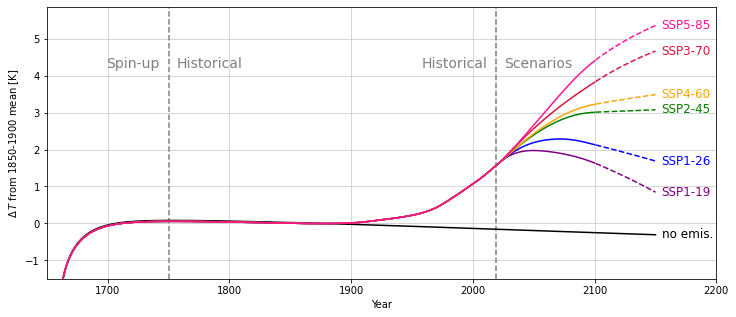

In [53]:
scenarios = ['ssp1-19','ssp1-26', 'ssp2-45', 'ssp4-60', 'ssp3-70', 'ssp5-85']
paths = [f'https://raw.githubusercontent.com/dkrieger94/intro/master/scen/{s}.txt' for s in scenarios]
colors = ['purple',  'blue', 'green', 'orange', 'crimson', 'deeppink']
years = np.arange(1650., 2151., 1)
first_year = 1650.

ymax = 0

## model init
emissivity_gradient = 0.01
use_constant_albedo_land = False
use_constant_albedo_icefree = False
# mixing_scale = 3.2
# albedo_b=0.1
# albedo_carbon_coeff=-0.01

fig, ax = plt.subplots(figsize=(12,5))

model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                emissivity_gradient=0.01,
                emissions_scenario=0.,
                use_constant_albedo_land=use_constant_albedo_land,
                use_constant_albedo_icefree=use_constant_albedo_icefree,
                active_components=3)
    
time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)

tequil = np.mean(output['ts'][(time>=1850.) & (time<=1900)])
ax.plot(time[time>=first_year], output['ts'][time>=first_year]-tequil, color='black')
ax.text(2155, output['ts'][-1]-tequil, 'no emis.', ha='left', va='center', color='black', fontsize=12)

for i, scenario in enumerate(scenarios):

    model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                emissivity_gradient=0.01,
                emissions_scenario=paths[i],
                use_constant_albedo_land=use_constant_albedo_land,
                use_constant_albedo_icefree=use_constant_albedo_icefree,
                active_components=3)
    
    time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)

    tequil = np.mean(output['ts'][(time>=1850.) & (time<=1900)])
    ax.plot(time[(time>=first_year) & (time<=2100.)], output['ts'][(time>=first_year) & (time<=2100.)]-tequil, color=colors[i])
    ax.plot(time[time>2100.], output['ts'][time>2100.]-tequil, color=colors[i], linestyle='--')
    ax.text(2155, output['ts'][-1]-tequil, scenario.upper(), ha='left', va='center', color=colors[i], fontsize=12)

    if np.max(output['ts']-tequil) > ymax:
        ymax = np.max(output['ts']-tequil)

ax.set_xlim(first_year, 2200)
ax.set_ylim(-1.5, ymax+0.5)
ax.grid(color='0.8')

ax.vlines(2019, ax.get_ylim()[0], ax.get_ylim()[1], colors='0.5', linestyles='--')
ax.text(2012, 4.2, 'Historical', ha='right', color='0.5', fontsize=14)
ax.text(2026, 4.2, 'Scenarios', ha='left', color='0.5', fontsize=14)

ax.vlines(1750, ax.get_ylim()[0], ax.get_ylim()[1], colors='0.5', linestyles='--')
ax.text(1743, 4.2, 'Spin-up', ha='right', color='0.5', fontsize=14)
ax.text(1757, 4.2, 'Historical', ha='left', color='0.5', fontsize=14)


ax.set_xlabel('Year')
ax.set_ylabel('$\Delta\,T$ from 1850-1900 mean [K]')

plt.savefig('scenarios_ts_varyingalbedo.png', dpi=200)


--------------- Initial state -----------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  [GtC]
Mixed Layer carbon: 733.2705882352941  [GtC]
Deep Ocean carbon: 36663.529411764706  [GtC]
Total carbon: 40490.4  [GtC]
ASR:  242.323  [W/m^2]
OLR:  237.86071060832683  [W/m^2]
NRI:  4.462289391673181  [W/m^2]
DSI:  32.0  [W/m^2]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:360: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:360: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


----- Model state after 500.00 years ------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  288.5823318630552  [K]
Ocean temperature:  288.2294670842264  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  438.46983845093206  [ppm]
Atmospheric carbon: 929.556057515976  [GtC]
Land carbon: 3100.9715822333355  [GtC]
Mixed Layer carbon: 749.5021012964435  [GtC]
Deep Ocean carbon: 36933.558150576595  [GtC]
Total carbon: 41713.58789162235  [GtC]
ASR:  242.323  [W/m^2]
OLR:  242.439060054935  [W/m^2]
NRI:  -0.11606005493499083  [W/m^2]
DSI:  1.1291672922519866  [W/m^2]
Total carbon emissions:  -6944.894000000004 [GtC]
Carbon storage absolute difference:  8168.081891622354 [GtC]
--------------- Initial state -----------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  [GtC]
Mixed Layer carbo

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:360: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


----- Model state after 500.00 years ------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  289.2942308248307  [K]
Ocean temperature:  288.4546722037931  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  740.0213582856786  [ppm]
Atmospheric carbon: 1568.8452795656387  [GtC]
Land carbon: 3353.8810421498883  [GtC]
Mixed Layer carbon: 767.6187082748781  [GtC]
Deep Ocean carbon: 37024.26267762011  [GtC]
Total carbon: 42714.607707610514  [GtC]
ASR:  242.323  [W/m^2]
OLR:  242.33925470592268  [W/m^2]
NRI:  -0.01625470592267675  [W/m^2]
DSI:  2.6865875873203553  [W/m^2]
Total carbon emissions:  -4308.893000000003 [GtC]
Carbon storage absolute difference:  6533.100707610515 [GtC]
--------------- Initial state -----------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  [GtC]
Mixed Layer ca

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:360: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


----- Model state after 500.00 years ------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  290.4226687512084  [K]
Ocean temperature:  288.8049545064571  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  1701.6136485136417  [ppm]
Atmospheric carbon: 3607.4209348489208  [GtC]
Land carbon: 3734.797379281172  [GtC]
Mixed Layer carbon: 822.2281942158575  [GtC]
Deep Ocean carbon: 37233.78134027245  [GtC]
Total carbon: 45398.22784861841  [GtC]
ASR:  242.323  [W/m^2]
OLR:  242.20614456033968  [W/m^2]
NRI:  0.11685543966032697  [W/m^2]
DSI:  5.176685583204199  [W/m^2]
Total carbon emissions:  4841.429500000002 [GtC]
Carbon storage absolute difference:  66.39834861840427 [GtC]
--------------- Initial state -----------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  [GtC]
Mixed Layer carbon

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:360: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


----- Model state after 500.00 years ------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  290.7452247572524  [K]
Ocean temperature:  288.8928217334306  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  2163.9839147540765  [ppm]
Atmospheric carbon: 4587.645899278642  [GtC]
Land carbon: 3831.9272987522168  [GtC]
Mixed Layer carbon: 846.7785548369885  [GtC]
Deep Ocean carbon: 37305.27876248383  [GtC]
Total carbon: 46571.63051535168  [GtC]
ASR:  242.323  [W/m^2]
OLR:  242.16470424842248  [W/m^2]
NRI:  0.1582957515775263  [W/m^2]
DSI:  5.927689676229784  [W/m^2]
Total carbon emissions:  10962.505000000005 [GtC]
Carbon storage absolute difference:  4881.274484648326 [GtC]
--------------- Initial state -----------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  [GtC]
Mixed Layer carbon

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:360: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


----- Model state after 500.00 years ------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  291.6375213923787  [K]
Ocean temperature:  289.1419210631467  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  4215.372809820819  [ppm]
Atmospheric carbon: 8936.590356820137  [GtC]
Land carbon: 4091.5753926341417  [GtC]
Mixed Layer carbon: 952.4023617636002  [GtC]
Deep Ocean carbon: 37580.687952041284  [GtC]
Total carbon: 51561.25606325916  [GtC]
ASR:  242.323  [W/m^2]
OLR:  242.0620185291253  [W/m^2]
NRI:  0.2609814708746967  [W/m^2]
DSI:  7.98592105354237  [W/m^2]
Total carbon emissions:  41362.91650000001 [GtC]
Carbon storage absolute difference:  30292.060436740845 [GtC]
--------------- Initial state -----------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  [GtC]
Mixed Layer carbon: 

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


----- Model state after 500.00 years ------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  292.1410305516519  [K]
Ocean temperature:  289.3272505776688  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  6123.59119528847  [ppm]
Atmospheric carbon: 12982.013334011557  [GtC]
Land carbon: 4253.31662561583  [GtC]
Mixed Layer carbon: 1054.8045086541772  [GtC]
Deep Ocean carbon: 37887.71342256442  [GtC]
Total carbon: 56177.84789084598  [GtC]
ASR:  242.323  [W/m^2]
OLR:  242.03367117082996  [W/m^2]
NRI:  0.28932882917004576  [W/m^2]
DSI:  9.004095916745973  [W/m^2]
Total carbon emissions:  63143.655000000035 [GtC]
Carbon storage absolute difference:  47456.20710915406 [GtC]


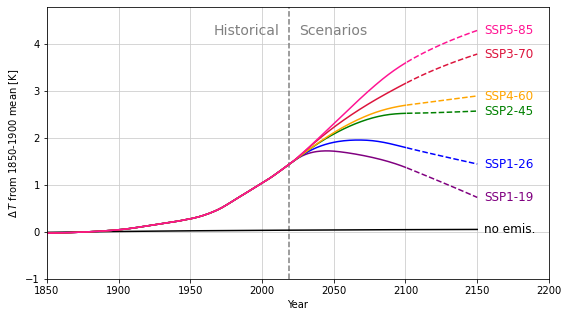

In [54]:
scenarios = ['ssp1-19','ssp1-26', 'ssp2-45', 'ssp4-60', 'ssp3-70', 'ssp5-85']
paths = [f'https://raw.githubusercontent.com/dkrieger94/intro/master/scen/{s}.txt' for s in scenarios]
colors = ['purple',  'blue', 'green', 'orange', 'crimson', 'deeppink']
years = np.arange(1650., 2151., 1)
first_year = 1850.

ymax = 0

## model init
use_constant_albedo_land = True
use_constant_albedo_icefree = True
# mixing_scale = 3.2
# albedo_b=0.1
# albedo_carbon_coeff=-0.01

fig, ax = plt.subplots(figsize=(9,5))

model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                emissions_scenario=0.,
                use_constant_albedo_land=use_constant_albedo_land,
                use_constant_albedo_icefree=use_constant_albedo_icefree,
                active_components=3)
    
time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)

tequil = np.mean(output['ts'][(time>=1850.) & (time<=1900)])
ax.plot(time[time>=first_year], output['ts'][time>=first_year]-tequil, color='black')
ax.text(2155, output['ts'][-1]-tequil, 'no emis.', ha='left', va='center', color='black', fontsize=12)

for i, scenario in enumerate(scenarios):

    model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                emissions_scenario=paths[i],
                use_constant_albedo_land=use_constant_albedo_land,
                use_constant_albedo_icefree=use_constant_albedo_icefree,
                active_components=3)
    
    time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=True)

    tequil = np.mean(output['ts'][(time>=1850.) & (time<=1900)])
    ax.plot(time[(time>=first_year) & (time<=2100.)], output['ts'][(time>=first_year) & (time<=2100.)]-tequil, color=colors[i])
    ax.plot(time[time>2100.], output['ts'][time>2100.]-tequil, color=colors[i], linestyle='--')
    ax.text(2155, output['ts'][-1]-tequil, scenario.upper(), ha='left', va='center', color=colors[i], fontsize=12)

    if np.max(output['ts']-tequil) > ymax:
        ymax = np.max(output['ts']-tequil)

ax.set_xlim(first_year, 2200)
ax.set_ylim(-1, ymax+0.5)
ax.grid(color='0.8')

ax.vlines(2019, ax.get_ylim()[0], ax.get_ylim()[1], colors='0.5', linestyles='--')
ax.text(2012, 4.2, 'Historical', ha='right', color='0.5', fontsize=14)
ax.text(2026, 4.2, 'Scenarios', ha='left', color='0.5', fontsize=14)

ax.set_xlabel('Year')
ax.set_ylabel('$\Delta\,T$ from 1850-1900 mean [K]')

plt.savefig('scenarios_ts_varyingalbedo_short.png', dpi=200)


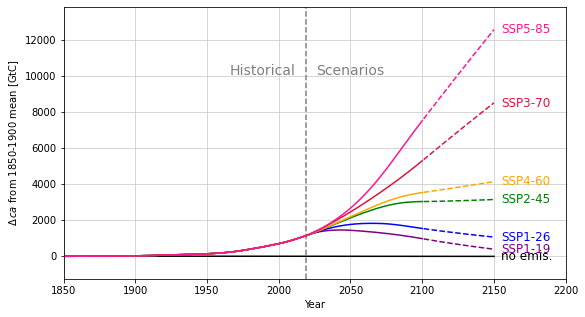

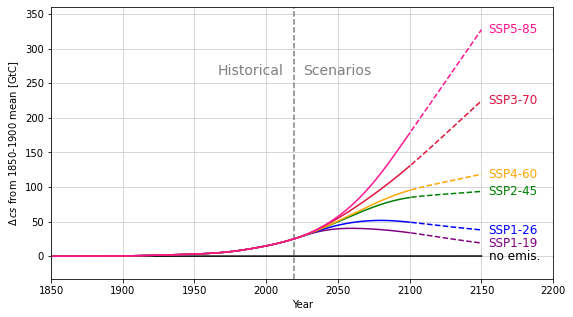

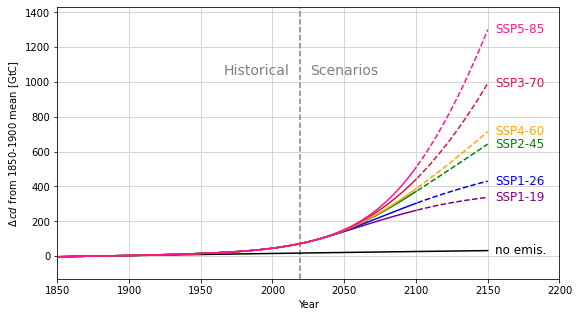

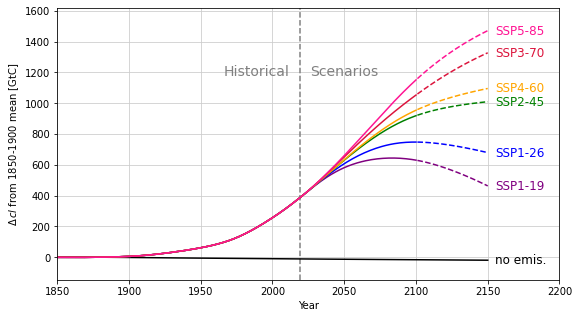

In [57]:
scenarios = ['ssp1-19','ssp1-26', 'ssp2-45', 'ssp4-60', 'ssp3-70', 'ssp5-85']
paths = [f'https://raw.githubusercontent.com/dkrieger94/intro/master/scen/{s}.txt' for s in scenarios]
colors = ['purple',  'blue', 'green', 'orange', 'crimson', 'deeppink']
years = np.arange(1650., 2151., 1)
first_year = 1850.

## model init
use_constant_albedo_land = True
use_constant_albedo_icefree = False
# mixing_scale = 3.2
# albedo_b=0.1
# albedo_carbon_coeff=-0.01

for c in ['ca', 'cs', 'cd', 'cl']:

    ymax = 0

    fig, ax = plt.subplots(figsize=(9,5))

    model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                    emissions_scenario=0.,
                    use_constant_albedo_land=use_constant_albedo_land,
                    use_constant_albedo_icefree=use_constant_albedo_icefree,
                    active_components=3)
        
    time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)

    tequil = np.mean(output[c][(time>=1850.) & (time<=1900)])
    ax.plot(time[time>=first_year], output[c][time>=first_year] -tequil, color='black')
    ax.text(2155, output[c][-1]-tequil, 'no emis.', ha='left', va='center', color='black', fontsize=12)

    for i, scenario in enumerate(scenarios):

        model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                    emissions_scenario=paths[i],
                    use_constant_albedo_land=use_constant_albedo_land,
                    use_constant_albedo_icefree=use_constant_albedo_icefree,
                    active_components=3)
        
        time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)

        tequil = np.mean(output[c][(time>=1850.) & (time<=1900)])
        ax.plot(time[(time>=first_year) & (time<=2100.)], output[c][(time>=first_year) & (time<=2100.)]-tequil, color=colors[i])
        ax.plot(time[time>2100.], output[c][time>2100.]-tequil, color=colors[i], linestyle='--')
        ax.text(2155, output[c][-1]-tequil, scenario.upper(), ha='left', va='center', color=colors[i], fontsize=12)

        if np.max(output[c]-tequil) > ymax:
            ymax = np.max(output[c]-tequil)

    ax.set_xlim(first_year, 2200)
    ax.set_ylim(-ymax*0.1, ymax*1.1)
    ax.grid(color='0.8')

    ax.vlines(2019, ax.get_ylim()[0], ax.get_ylim()[1], colors='0.5', linestyles='--')
    ax.text(2012, ymax*0.8, 'Historical', ha='right', color='0.5', fontsize=14)
    ax.text(2026, ymax*0.8, 'Scenarios', ha='left', color='0.5', fontsize=14)

    ax.set_xlabel('Year')
    ax.set_ylabel(f'$\Delta\,{c}$ from 1850-1900 mean [GtC]')

    plt.savefig(f'scenarios_{c}_varyingalbedo_short.png', dpi=200)
    plt.show()


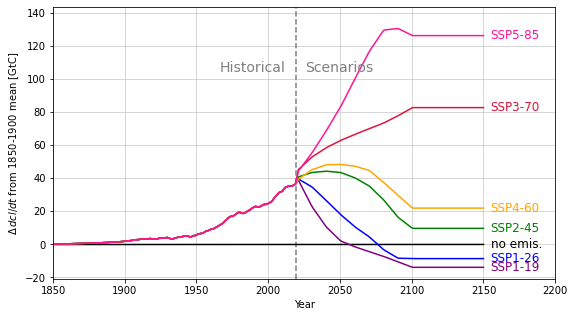

In [66]:
scenarios = ['ssp1-19','ssp1-26', 'ssp2-45', 'ssp4-60', 'ssp3-70', 'ssp5-85']
paths = [f'https://raw.githubusercontent.com/dkrieger94/intro/master/scen/{s}.txt' for s in scenarios]
colors = ['purple',  'blue', 'green', 'orange', 'crimson', 'deeppink']
years = np.arange(1650., 2151., 1)
first_year = 1850.

## model init
use_constant_albedo_land = True
use_constant_albedo_icefree = False
# mixing_scale = 3.2
# albedo_b=0.1
# albedo_carbon_coeff=-0.01


ymax = 0
ymin = 0

fig, ax = plt.subplots(figsize=(9,5))

model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                emissions_scenario=0.,
                use_constant_albedo_land=use_constant_albedo_land,
                use_constant_albedo_icefree=use_constant_albedo_icefree,
                active_components=3)
    
time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)
output_c = output[c][time>=first_year][1:] - output[c][time>=first_year][:-1]
ax.plot(time[time>=first_year+1], output_c, color='black')
ax.text(2155, output[c][-1]-output[c][-2], 'no emis.', ha='left', va='center', color='black', fontsize=12)

for i, scenario in enumerate(scenarios):

    model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                emissions_scenario=paths[i],
                use_constant_albedo_land=use_constant_albedo_land,
                use_constant_albedo_icefree=use_constant_albedo_icefree,
                active_components=3)
    
    time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)
    
    for j, c in enumerate(['ca', 'cs', 'cd', 'cl']):
        if j == 0:
            output_c = output[c][time>=first_year][1:] - output[c][time>=first_year][:-1]
        else:
            output_c += output[c][time>=first_year][1:] - output[c][time>=first_year][:-1]

    ax.plot(time[time>=first_year+1], output_c, color=colors[i])
    ax.text(2155, output_c[-1], scenario.upper(), ha='left', va='center', color=colors[i], fontsize=12)

    if np.max(output_c) > ymax:
        ymax = np.max(output_c)

    if np.min(output_c) < ymin:
        ymin = np.min(output_c)

ax.set_xlim(first_year, 2200)
ax.set_ylim(ymin*1.5, ymax*1.1)
ax.grid(color='0.8')

ax.vlines(2019, ax.get_ylim()[0], ax.get_ylim()[1], colors='0.5', linestyles='--')
ax.text(2012, ymax*0.8, 'Historical', ha='right', color='0.5', fontsize=14)
ax.text(2026, ymax*0.8, 'Scenarios', ha='left', color='0.5', fontsize=14)

ax.set_xlabel('Year')
ax.set_ylabel(f'$\Delta\,d{c}/dt$ from 1850-1900 mean [GtC]')

plt.savefig(f'scenarios_dcdt_varyingalbedo_short.png', dpi=200)
plt.show()


-0.0025 -0.4650822166337889
-0.005 -0.299662186756791
-0.01 0.0
-0.02 0.5162391184675812
-0.04 1.3631478705175937
0.0 1.7183641553729103
0.0125 2.2075607108110944
0.025 1.0259667661113667
0.05 0.0
0.0625 -0.048490718795619614
0.07500000000000001 -0.05495898571621183
0.0 -0.05334346813418733
0.8 -0.03670072547743075
1.6 -0.013764737329950094
3.2 0.0
4.0 -0.006193382554272375
4.800000000000001 -0.01636947681129186


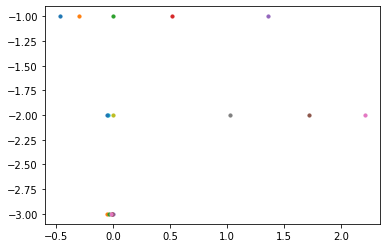

In [4]:
scenario = 'ssp2-45'
path_scen = f'https://raw.githubusercontent.com/dkrieger94/intro/master/scen/{scenario}.txt'

def get_2100(**kwargs):
    model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                emissions_scenario=path_scen,
                use_constant_albedo_land=False,
                use_constant_albedo_icefree=False,
                active_components=3,
                **kwargs)
    
    time, output = model.integrate(sim_time=np.arange(1650., 2101., 1), out_freq=1., update_state=True, is_relative_time=False, verbose=False)

    tequil = np.mean(output['ts'][(time>=1850.) & (time<=1900)])
    output['ts'] -= tequil

    return output['ts'][-1]



fig, ax = plt.subplots()


albedo_carbon_coeff_default = -0.01
for i, x in enumerate([-0.0025, -0.005, -0.01, -0.02, -0.04]):
    default = get_2100(albedo_carbon_coeff=albedo_carbon_coeff_default)
    temp = get_2100(albedo_carbon_coeff=x)
    print(x, temp-default)
    ax.scatter(temp-default, -1, s=10)

albedo_b_default = 0.05
albedo_b = [albedo_b_default * i for i in [0., 0.25, 0.5, 1., 1.25, 1.5]]
for i, x in enumerate(albedo_b):
    default = get_2100(albedo_b=albedo_b_default)
    temp = get_2100(albedo_b=x)
    print(x, temp-default)
    ax.scatter(temp-default, -2, s=10)

mixing_scale_default = 3.2
mixing_scale = [mixing_scale_default * i for i in [0., 0.25, 0.5, 1., 1.25, 1.5]]
for i, x in enumerate(mixing_scale):
    default = get_2100(mixing_scale=mixing_scale_default)
    temp = get_2100(mixing_scale=x)
    print(x, temp-default)
    ax.scatter(temp-default, -3, s=10)


In [92]:
albedo_carbon_coeff = [albedo_carbon_coeff_default * i for i in range(1, 11)] + [albedo_carbon_coeff_default / i for i in range(2, 11)]

In [88]:
albedo_carbon_coeff_default = -0.01

In [93]:
albedo_carbon_coeff

[-0.01,
 -0.02,
 -0.03,
 -0.04,
 -0.05,
 -0.06,
 -0.07,
 -0.08,
 -0.09,
 -0.1,
 -0.005,
 -0.0033333333333333335,
 -0.0025,
 -0.002,
 -0.0016666666666666668,
 -0.0014285714285714286,
 -0.00125,
 -0.0011111111111111111,
 -0.001]